In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import sqlite3
import pickle

In [2]:
#We load the data and drop rows with missing values leaving us with 333 rows of data with datatypes displayed as well.
penguins = sns.load_dataset("penguins").dropna()
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


### Feature Selection
In a more complex task it makes sense to discover and experiment with the potential difference of using different feature selection methods, i.e. Filter, Wrapper, Embedded or Permutation methods. I did some experimentation but found that my accuracy was equally high for all methods tried.

In this case I therefore decide to use Embedded method of Random Forest Classifier to uncover feature importance within the dataset.

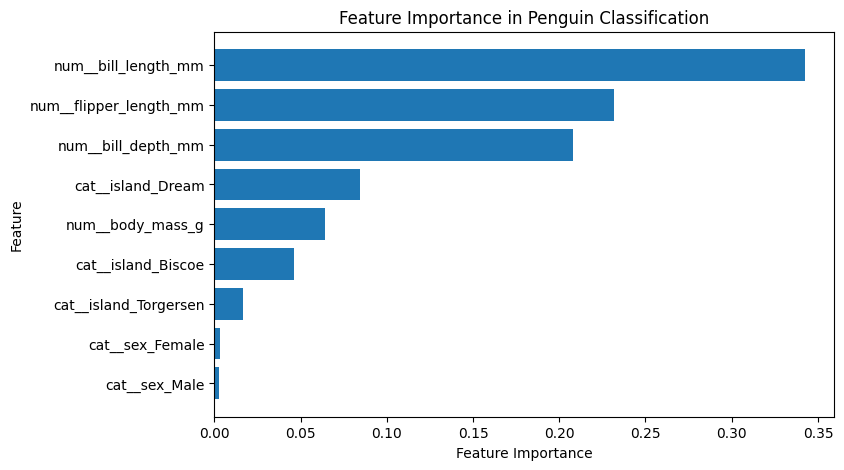

                  Feature  Importance
0     num__bill_length_mm    0.342341
2  num__flipper_length_mm    0.231628
1      num__bill_depth_mm    0.208113
5       cat__island_Dream    0.084639
3        num__body_mass_g    0.064062
4      cat__island_Biscoe    0.046319
6   cat__island_Torgersen    0.016745
7         cat__sex_Female    0.003342
8           cat__sex_Male    0.002811


In [3]:
#I set species as my target column as this is what we want to predict and then I use all features.
target = "species"
features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "island", "sex"]

X = penguins[features]
y = penguins[target]

#I use label encoder becuase our target variable needs to be numerical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#I define my numerical features and categorial features
num_features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
cat_features = ["island", "sex"]

#I scale numerical features and use one-hot encoder for categorial features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
    ]
)

#I split data with 80/20 distribution between train and test respectively
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

#I define my random forest classifier and apply it to the train data
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

#I get the features and their importance and plot them
rf_model = model.named_steps["classifier"]
feature_names = (
    model.named_steps["preprocessor"]
    .get_feature_names_out()
)
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Penguin Classification")
plt.gca().invert_yaxis()
plt.show()
print(importance_df)


Here we can see that the numerical categories are particularly important following our feature extraction using embedded method random forest classifier. One categorial feature is also important meaning that if a pinguin is from island_1 its an important feature, but other types for this feature mean less importance, hence we can conclude that the most important features are: num_bill_length_mm, num_flipper_length_mm, num_bill_depth_mm, num_body_mass_g 

### Database setup
Now that I know what features to use moving forward I save the data in an SQL database.

In [4]:
#Setting up data in SQL database
features_df = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g','species']].drop_duplicates().reset_index(drop=True)

In [5]:
#I setup database in SQLite and cursor
conn = sqlite3.connect("data/PenguinAlert.sqlite")
cursor = conn.cursor()

In [6]:
#I create my table the scheme of the features I decided on with species and also with generated IDs as primary key as we dont have a key from the inital penguin data
cursor.execute('''
    CREATE TABLE IF NOT EXISTS PenguinProperties (
        ID INTEGER PRIMARY KEY AUTOINCREMENT,
        bill_length_mm REAL,
        bill_depth_mm REAL,
        flipper_length_mm REAL,
        body_mass_g REAL,
        species TEXT
    )
''')

In [7]:
#I add my data to the database into the table with scheme that was decided above
features_df.to_sql('PenguinProperties', conn, if_exists='append', index=False)

333

In [8]:
#I inspect top 5 rows
print(pd.read_sql_query("SELECT * FROM PenguinProperties LIMIT 5;", conn))

   ID  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g species
0   1            39.1           18.7              181.0       3750.0  Adelie
1   2            39.5           17.4              186.0       3800.0  Adelie
2   3            40.3           18.0              195.0       3250.0  Adelie
3   4            36.7           19.3              193.0       3450.0  Adelie
4   5            39.3           20.6              190.0       3650.0  Adelie


In [9]:
#Close connection
conn.close()

### Training model to predict Species

In [10]:
#Connect to database and fetch our data from PenguinProperties Table
conn = sqlite3.connect("data/PenguinAlert.sqlite")
df = pd.read_sql_query("SELECT * FROM PenguinProperties;", conn)
conn.close()

#Define target y and features
X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = df['species']

#Encode cuz we need numerical label prediction when using random forrest classifier
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Split train test 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

#Model setup
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#Predict
y_pred = clf.predict(X_test)

#Simple evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

Model Accuracy: 100.00%


In [11]:
#I do a test prediction just to see, and it seems to predict as expected
sample_input = np.array([[42, 18.5, 195, 4000]])
predicted_label = clf.predict(sample_input)[0]
predicted_species = label_encoder.inverse_transform([predicted_label])[0]
print(predicted_species)

Adelie


c:\Users\Esben\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [12]:
#I Use pickle to save the model properties
with open("models/penguin_classifier.pkl", "wb") as f:
    pickle.dump(clf, f)
with open("models/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


### Export model
After having made the model and exported I set up script "CatchPenguin.py" which utilizes the model using API call to fetch the daily penguin, where I will predict its species using the model created here.